In [102]:
import torch

from torch import nn
from torch.nn import functional as F

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

In [103]:
device = (
    "cuda"  # nvidia GPU
    if torch.cuda.is_available()
    else "mps"  # mac GPU
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# Prepare dataset

In [136]:
train_df = pd.read_csv("data/train/train.csv")
train_df.head(5)

,filename,building,camera,height
0,photo_1_2024-02-28_19-50-55.jpg,"55.83374598606761, 37.4863818073886","55.83355618950865, 37.48563078891009",24
1,photo_2_2024-02-28_19-50-55.jpg,"55.74671515046505, 37.49455264385141","55.74689329318663, 37.49520710283597",21
2,photo_3_2024-02-28_19-50-55.jpg,"55.759007045864244, 37.71650413890229","55.758900299637965, 37.71613626315986",18
3,photo_4_2024-02-28_19-50-55.jpg,"55.781247169148855, 37.540942963066165","55.78183117969778, 37.54023985374589",18
4,photo_5_2024-02-28_19-50-55.jpg,"55.63435687287336, 37.765668872386286","55.63416610435083, 37.76433849674555",51


In [137]:
class CoordinatesTransformPipeline:
    def __init__(self, df: pd.DataFrame):
        self.df = df
        
    @staticmethod
    def distance(x: np.ndarray, y: np.ndarray) -> float:
        """
        Great-circle distance: https://en.wikipedia.org/wiki/Great-circle_distance
        Returns distance between x and y in meters
        """
        x, y = np.radians(x), np.radians(y)
        r = 6_371_000  # meters
        delta_lambda = np.abs(x[1] - y[1])
        return np.arccos(np.sin(x[0]) * np.sin(y[0]) + 
                         np.cos(x[0]) * np.cos(y[0]) * 
                         np.cos(delta_lambda)) * r
    
    def transform(self) -> pd.DataFrame:
        coords_columns = ["building", "camera"]

        for col in coords_columns:
            self.df[col] = self.coords_transform(self.df[col])

        dists = []
        for i in range(len(self.df)):
            dists.append(self.distance(
                self.df[coords_columns[0]].iloc[i],
                self.df[coords_columns[1]].iloc[i]
            ))
        self.df["distance"] = pd.Series(dists)
        return self.df.drop(columns=coords_columns)[["filename", "distance", "height"]]
            
    
    def coords_transform(self, column: pd.Series) -> pd.Series:
        splited = column.str.split(",")
        result = []
        for i in range(len(self.df)):
            result.append(np.array(
                splited.iloc[i], 
                dtype=np.float64)
            )
        return pd.Series(result)

In [138]:
transformer = CoordinatesTransformPipeline(train_df)
train_df = transformer.transform()
train_df.head(5)

,filename,distance,height
0,photo_1_2024-02-28_19-50-55.jpg,51.428476,24
1,photo_2_2024-02-28_19-50-55.jpg,45.498280,21
2,photo_3_2024-02-28_19-50-55.jpg,25.896985,18
3,photo_4_2024-02-28_19-50-55.jpg,78.422418,18
4,photo_5_2024-02-28_19-50-55.jpg,86.155339,51


In [139]:
class BuildingDataset(torch.utils.data.Dataset):
    """
    Torch dataset
    
    Returns tuple of form: tensor_image, tensor_dist, tensor_y
    
    - tensor_image is image of shape (n_channels, height, width),
    - tensor_dist is distance between camera and building in meters,
    - tensor_y is target.
    """
    normalize_params = {
        "mean": None,
        "std": None
    }
    
    def __init__(self, folder: str, df: pd.DataFrame):
        self.df = df
        self.df[["distance", "height"]] = self.numerical_normalize(self.df[["distance", "height"]])
        self.folder = folder
        
    def __len__(self) -> int:
        return len(self.df)
    
    @staticmethod
    def image2tensor(pic: Image, device: str = None) -> torch.Tensor:
        img = torch.as_tensor(np.array(pic, copy=True), device=device)
        img = img.view(pic.size[1], pic.size[0], 3)
        # put it from HWC to CHW format
        img = img.permute((2, 0, 1))
        return img
    
    def numerical_normalize(self, data: pd.DataFrame | float | int) -> pd.DataFrame | float:
        """
        Returns normalized data.
        """
        if self.normalize_params["mean"] is None and self.normalize_params["std"] is None:
            self.normalize_params["mean"] = data.mean()
            self.normalize_params["std"] = data.std()

        data = (data - self.normalize_params["mean"]) / self.normalize_params["std"]
        return data
    
    def __getitem__(self, key: int) -> tuple[torch.Tensor,
                                             torch.Tensor,
                                             torch.Tensor]:
        filename = f"{self.folder}/{self.df['filename'].iloc[key]}"
        
        return (self.image2tensor(Image.open(filename), device=device),
                torch.tensor(self.df["distance"].iloc[key], device=device, dtype=torch.float32),
                torch.tensor(self.df["height"].iloc[key], device=device, dtype=torch.float32))

torch.Size([3, 600, 920]) torch.Size([]) torch.Size([])


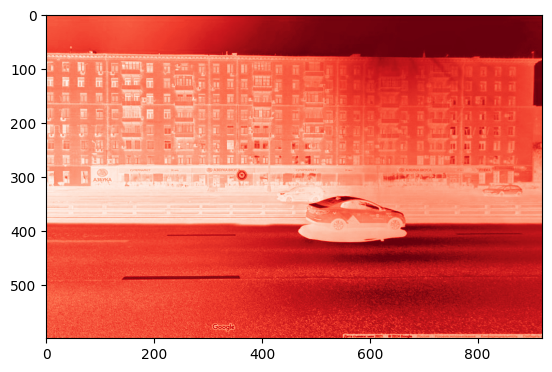

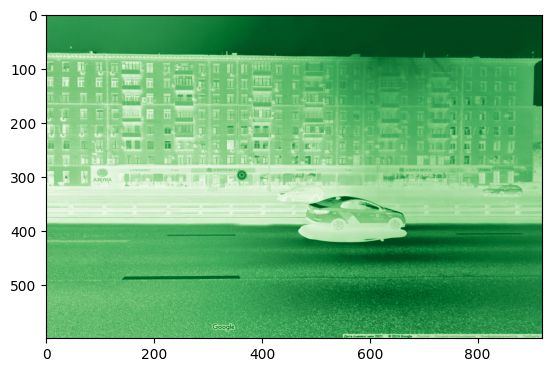

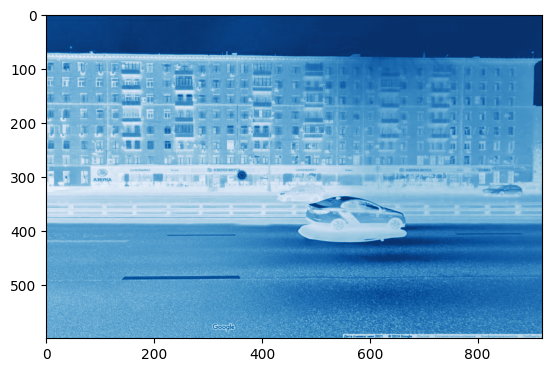

In [140]:
dataset = BuildingDataset("data/train", train_df)
for image, x, y in dataset:
    print(image.shape, x.shape, y.shape)
    for channel, cm in zip(image, ["Reds", "Greens", "Blues"]):
        plt.imshow(channel.to("cpu"), cmap=cm)
        plt.show()
    break

In [141]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, pin_memory=True)

# test batches
for i, (image, x, y) in enumerate(dataloader):
    print(f"Batch num: {i}, input: {image.shape}, {x.shape}, {y.shape}, devices: {image.device}, {x.device}, {y.device}", end="\n\n")

Batch num: 0, input: torch.Size([4, 3, 600, 920]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 1, input: torch.Size([4, 3, 600, 920]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 2, input: torch.Size([4, 3, 600, 920]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 3, input: torch.Size([4, 3, 600, 920]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

Batch num: 4, input: torch.Size([4, 3, 600, 920]), torch.Size([4]), torch.Size([4]), devices: mps:0, mps:0, mps:0

